<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">PART 4. DATA TRANSFORMATION - SCALING</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<a id='4.1'>
    <h2 style='font-size:180%;'>
        Libraries</h2></a>

In [1]:
# general
import numpy as np
import pandas as pd
import random as rd
import copy

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats
from scipy.stats import (
    pearsonr, spearmanr, kendalltau,
    chi2_contingency, f_oneway)

# machine learning prep
from sklearn.preprocessing import (
    MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer)
from collections import Counter
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, auc, roc_auc_score,
    precision_recall_curve, plot_precision_recall_curve, average_precision_score, precision_recall_fscore_support,
    classification_report, precision_recall_fscore_support, confusion_matrix, SCORERS)
from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import (SVC, LinearSVC) # remove SVC later if not used
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, IsolationForest)
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
# warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

# saving
import os

In [2]:
# settings
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True, precision=3)

In [3]:
# pd.set_options('precision', 3)
# pd.set_options('min_rows', 6)
# pd.set_options('max_rows', 10)
# pd.reset_option('max_rows')
# pd.set_option('max_colwidth', 10)
# pd.set_option("chop_threshold", 0.5)
# pd.reset_option("chop_threshold")
# pd.set_option("colheader_justify", "left")
# pd.reset_option("colheader_justify")
# plt.rc('figure',figsize=(8,4))
# plt.style.use('seaborn-whitegrid')
# from IPython.display import display, Math, Latex
# pio.renderers.default='plotly_mimetype'

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Data Loading</h2></a>

In [4]:
# load data
d = pd.read_csv('source/d_num.csv')
d.head(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,opentobuy_avg_r12,utilratio_avg,tx_amt_r12,tx_ct_r12,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1,marstat_Divorced,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
0,0,45,1,3,5,39,1,3,777.00,"12,691.00","11,914.00",0.06,"1,144.00",42,1.33,1.62,0,1,0,0,1,0,0,0,1,3,27.24
1,0,49,0,5,6,44,1,2,864.00,"8,256.00","7,392.00",0.10,"1,291.00",33,1.54,3.71,0,0,1,0,1,0,0,0,3,1,39.12
2,0,51,1,3,4,36,1,0,0.00,"3,418.00","3,418.00",0.00,"1,887.00",20,2.59,2.33,0,1,0,0,1,0,0,0,3,4,94.35


<a id='4.2'>
    <h2 style='font-size:180%;'>
        Train Test Split</h2></a>

In [11]:
d_values = d.values
x, y = d_values[:,1:], d_values[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Functions to Use</h2>

In [17]:
def perf_metrics(y_test, yhat):
    dic = {}
    accuracy = round(accuracy_score(y_test, yhat), 4)
    precision = round(precision_score(y_test, yhat), 4)
    recall = round(recall_score(y_test, yhat), 4)
    f1 = round(f1_score(y_test, yhat), 4)
    f2 = round(fbeta_score(y_test, yhat, beta=2), 4)
    dic['accuracy'] = round(accuracy*100,2)
    dic['precision'] = round(precision*100,2)
    dic['recall'] = round(recall*100,2)
    dic['f1'] = round(f1*100,2)
    dic['f2'] = round(f2*100,2)
    return dic

In [48]:
def results_complete(models, scaler, resampling, set_applied='validation'):
    
    results, names = [], []
    scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    for name, model in models:
        pipeline = Pipeline([('scaler', scaler), ('resampling', resampling), ('model', model)])
        
        # validation set
        if set_applied=='validation':  
            cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
            results_dic = cross_validate(
                pipeline, x_train, y_train, cv=cv, 
                scoring=scoring, return_train_score=True, n_jobs=-1)
        
        # test set
        else:  
            pipeline.fit(x_train, y_train)
            yhat = pipeline.predict(x_test)
            results_dic = perf_metrics(y_test, yhat) 
            
        # complile results    
        names.append(name)
        results.append(results_dic)            
    results_dic = dict(zip(names, results))
    return results_dic

In [9]:
def results_validation(models, scaler):
    results = []
    names = []
    scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    for name, model in models:
        pipeline = Pipeline([('scaler', scaler),('m', model)])
        
        
        # apply on cross validation sets generated by Stratified K Fold
        cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)        
        cv_results = cross_validate(
            pipeline, x_train, y_train, cv=cv, 
            scoring=scoring, return_train_score=True, n_jobs=-1)
        
        
        # create a list of model names
        names.append(name)
        # create a list of dictionaries of all metrics for each model
        results.append(cv_results)
    results_dic = dict(zip(names, results))
    return results_dic

In [10]:
def results_test(models, scaler):
    results = []
    names = []
    scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    for name, model in models:
        pipeline = Pipeline([('scaler', scaler),('m', model)])
        
        
        # apply on the test set   
        pipeline.fit(x_train, y_train)
        yhat = pipeline.predict(x_test)
        test_metrics = perf_metrics(y_test, yhat)
        
        
        # create a list of model names
        names.append(name)
        # create a list of dictionaries of all metrics for each model
        results.append(test_metrics)
    results_dic = dict(zip(names, results))
    return results_dic

In [39]:
def results_summary_df(results_dic):
    names, results = [], []
    for k,v in results_dic.items():
        names.append(k)
        results.append(v)
    results_summary_df = pd.DataFrame()
    for i in np.arange(len(names)):
        results_metric = []
        results_mean = []
        results_std = []
        for k,v in results[i].items():
            results_metric.append(k)
            results_mean.append(np.round(np.mean(v),3))
            results_std.append(np.round(np.std(v),3))
        df = pd.DataFrame(
                list(zip(results_metric, results_mean, results_std, [names[i] for ct in np.arange(len(results[0]))])), 
                columns=['metric', 'mean', 'std', 'mod'])
        df = df.set_index(['mod','metric']).stack().unstack([1,2])
        results_summary_df = pd.concat([results_summary_df, df])
    return(results_summary_df)

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Resampling</h2>

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

In [41]:
# create a list of tuples for all models to explore: [(`model name`, `model instance`)]
models = []
models.append(('LR', LogisticRegression(solver='saga', max_iter=10000, class_weight='balanced', random_state=5))) # `max_iter` from 1000 to 10000 due to convergence issue
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=1)))
models.append(('CART', DecisionTreeClassifier(random_state=5)))
models.append(('RF', RandomForestClassifier(random_state=5)))
models.append(('NB', GaussianNB()))
models.append(('GB', GradientBoostingClassifier(random_state=5)))
models.append(('MLP', MLPClassifier(max_iter=1000, random_state=5)))

In [49]:
scaler = QuantileTransformer()
resampling = ADASYN(random_state=5)

In [50]:
results_dic = results_complete(models, scaler, resampling, set_applied='validation')

In [51]:
results_adasyn_validation = results_summary_df(results_dic)
results_adasyn_validation

metric fit_time       score_time      test_accuracy      train_accuracy       \
           mean   std       mean  std          mean  std           mean  std   
mod                                                                            
LR         2.00  0.58       0.03 0.01          0.84 0.01           0.84 0.00   
LDA        1.29  0.37       0.03 0.01          0.83 0.01           0.83 0.00   
KNN        1.53  0.31       1.44 0.47          0.86 0.01           1.00 0.00   
CART       1.88  0.41       0.04 0.01          0.92 0.01           1.00 0.00   
RF        11.00  2.87       0.21 0.09          0.96 0.01           1.00 0.00   
NB         1.19  0.23       0.03 0.01          0.81 0.01           0.81 0.01   
GB        17.69  2.42       0.05 0.01          0.95 0.01           0.96 0.00   
MLP      207.47 52.61       0.10 0.04          0.94 0.01           0.98 0.01   

metric test_precision      train_precision      test_recall      train_recall  \
                 mean  std            mean  std        mean  std         mean   
mod                                                                             
LR               0.50 0.02            0.51 0.00        0.88 0.04         0.88   
LDA              0.48 0.02            0.48 0.00        0.90 0.03         0.90   
KNN              0.55 0.03            1.00 0.00        0.70 0.04         1.00   
CART             0.72 0.03            1.00 0.00        0.82 0.03         1.00   
RF               0.85 0.02            1.00 0.00        0.89 0.02         1.00   
NB               0.45 0.02            0.45 0.01        0.79 0.04         0.79   
GB               0.82 0.03            0.85 0.01        0.91 0.03         0.93   
MLP              0.78 0.03            0.90 0.04        0.84 0.04         0.98   

metric      test_f1      train_f1      test_roc_auc      train_roc_auc       
        std    mean  std     mean  std         mean  std          mean  std  
mod                                                                          
LR     0.00    0.64 0.02     0.64 0.00         0.93 0.01          0.94 0.00  
LDA    0.00    0.62 0.02     0.63 0.00         0.94 0.01          0.94 0.00  
KNN    0.00    0.61 0.03     1.00 0.00         0.80 0.02          1.00 0.00  
CART   0.00    0.77 0.02     1.00 0.00         0.88 0.01          1.00 0.00  
RF     0.00    0.87 0.02     1.00 0.00         0.99 0.00          1.00 0.00  
NB     0.02    0.57 0.02     0.58 0.01         0.87 0.02          0.88 0.00  
GB     0.00    0.86 0.02     0.89 0.00         0.99 0.00          0.99 0.00  
MLP    0.01    0.81 0.03     0.94 0.02         0.97 0.01          1.00 0.00

In [52]:
results_dic_test = results_complete(models, scaler, resampling, set_applied='test')

In [53]:
results_adasyn_test = results_summary_df(results_dic_test)
results_adasyn_test

metric accuracy      precision      recall         f1         f2     
           mean  std      mean  std   mean  std  mean  std  mean  std
mod                                                                  
LR        84.30 0.00     50.60 0.00  91.38 0.00 65.13 0.00 78.70 0.00
LDA       82.97 0.00     48.39 0.00  92.62 0.00 63.57 0.00 78.30 0.00
KNN       86.33 0.00     55.83 0.00  70.77 0.00 62.42 0.00 67.17 0.00
CART      93.14 0.00     74.22 0.00  87.69 0.00 80.39 0.00 84.62 0.00
RF        96.99 0.00     88.60 0.00  93.23 0.00 90.85 0.00 92.27 0.00
NB        79.37 0.00     42.13 0.00  76.62 0.00 54.37 0.00 65.84 0.00
GB        96.00 0.00     83.89 0.00  92.92 0.00 88.18 0.00 90.96 0.00
MLP       94.32 0.00     80.35 0.00  85.54 0.00 82.86 0.00 84.45 0.00

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Feature Selection</h2>

<a id='4.2'>
    <h2 style='font-size:240%;'>
        Procedures</h2></a>

1. Unsupervised: Multicollinearity Treatment
2. Supervised: Wrapper, Filter, Intrinsic Methods

<a id='4.2'>
    <h2 style='font-size:240%;'>
        Unsupervised</h2></a>

Unsupervised feature selection techniques ignore the target variables in selecting features. These techniques can be used to remove multicolinearity or redundancy.

1. Correlation 

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Multicollinearity</h2></a>

It can reduce our overall coefficient as well as our p-value (known as the significance value) and cause unpredictable variance. This will lead to overfitting where the model may do great on known training set but will fail at unknown testing set. As this leads to higher standard error with lower statistical significance value, multicollinearity makes it difficult to ascertain how important a feature is to the target variable. And with a lower significance value, we will fail to reject the null, which leads to type II error for our hypothesis testing.

1. Correlation - useful for 2 variables
2. VIF - useful for 2+ variables
3. ANOVA

Fortunately, there is a very simple test to assess multicollinearity in your regression model. The variance inflation factor (VIF) identifies correlation between independent variables and the strength of that correlation. My words --- A VIF of 1 is not collinear, but the higher the VIF, the higher the level of collinearity. A VIF of 5 or above should be reduced to a single variable by either removal or transformation such as PCA.

[Source: Towards Data Science - Multicollinearity in Data Science](https://towardsdatascience.com/multicollinearity-in-data-science-c5f6c0fe6edf)

1. Uncertainty in coefficient estimates or unstable variance: Small changes (adding/removing rows/columns) in the data results in change of coefficients.
1. Increased standard error: Reduces the accuracy of the estimates and increases the chances of detection.
1. Decreased statistical significance: Due to increased standard error, t-statistic declines which negatively impacts the capability of detecting statistical significance in coefficient leading to type-II error.
1. Reducing coefficient & p-value: The importance of the correlated explanatory variable is masked due to collinearity.
1. Overfitting: Leads to overfitting as is indicated by the high variance problem.

The heatmaps are definitely more intuitive & visual. However, it helps identify correlation between 2 variables strictly and fails to identify collinearity which exists between 3 or more variables, for which Variance Inflation Factor can be used.

<a id='4.2'>
    <h2 style='font-size:210%;'>
        How to Deal with Multicollinearity</h2></a>

[Source: Towards Data Science - Handling Multicollinearity](https://towardsdatascience.com/handling-multi-collinearity-6579eb99fd81)</br>
[Source: Medium - Handling Multicollinearity](https://medium.com/@zxr.nju/the-classical-linear-regression-model-is-good-why-do-we-need-regularization-c89dba10c8eb)

--My words
1. Regularization
    * Introduce penalization or remove one: Ridge Regression, Lasso, and Elastic Net can be used to eliminate redundant variables identified by the VIF. 
2. Transformation
    * PCA is a popular method

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Regularization</h2></a>

$Regularized Loss = Loss Function + Constraint$

**Ridge regression** is also called L2 regularization. It adds a constraint that is a linear function of the squared coefficients.
A critique of ridge regression is that all the variables tend to end up in the model. The model only shrinks the coefficients.

**Lasso** is also known as L1 regularization. It penalizes the model by the absolute weight coefficients.

**Elastic Net** is the combination of the L1 regularization and L2 regularization. It can both shrink the coefficients as well as eliminate some of the insignificant coefficients.

As we discussed above, choosing the right tuning parameter λ is quite important in regularization. For instance, ridge regression mainly solves the problem of multicollinearity. Therefore we want the tuning parameter λ to be relatively small in order to control the bias being introduced to the model. Lasso works well in terms of feature selection thus we want to balance between fitting the model and shrinking the coefficients.

Statistically, there are multiple available options for tuning parameter selection, including CV (Cross Validation), AIC (Akaike’s Information Criterion), and BIC (Bayesian Information Criterion).

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Transformation</h2></a>

PCA is a popular method.

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Correlation Matrix</h2></a>

In [56]:
# correlation map
def corr_map(d_sample, method):
    corr = d_sample.rank().corr(method=method)
    f,ax = plt.subplots(figsize=(12,12))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    arr = corr.values.ravel()
    arr = np.delete(arr, np.where(arr==1))
    sns.heatmap(corr, 
                ax=ax,
                mask=mask, 
                cmap=cmap, 
                annot=True, 
                linewidth=0.5,
                vmax=max(arr),
                vmin=min(arr),
                cbar_kws={"shrink": .5},
                fmt='.2f')
    ax.set_title(method.title() + ' Correlation Heatmap', fontsize=30)
    plt.show()

In [57]:
d_sample = d[['age', 'gender', 'dependents', 'prod_ct', 'mo_on_book',
       'mo_inactive_r12', 'contr_ct_r12', 'revbal_avg_r12', 'credlim_avg_r12',
       'opentobuy_avg_r12', 'utilratio_avg', 'tx_amt_r12', 'tx_ct_r12',
       'chng_tx_amt_q4_q1', 'chng_tx_ct_q4_q1', 'educ', 'inc',
       'tx_amt_pertx_r12']]

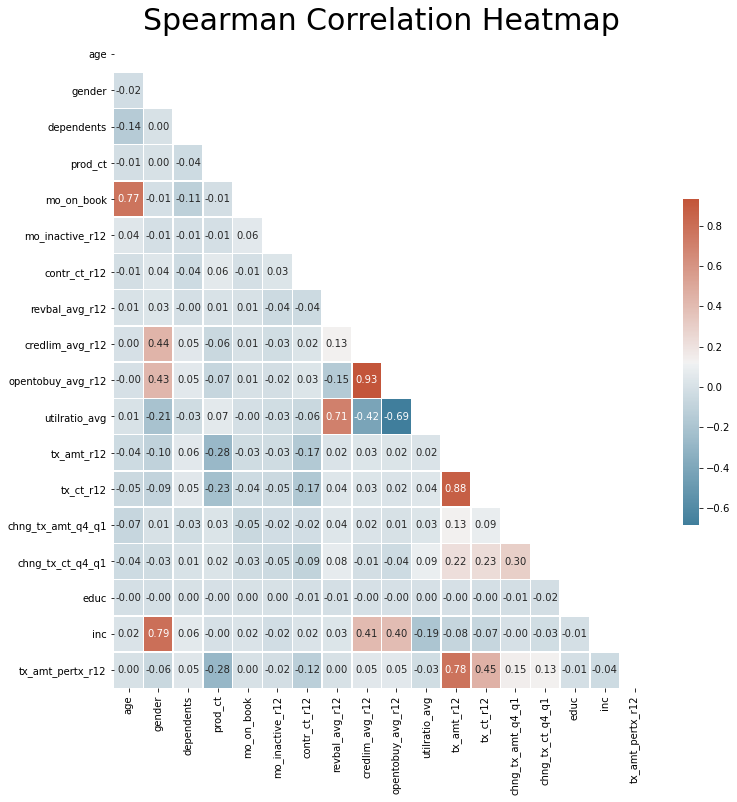

In [58]:
corr_map(d_sample, 'spearman')

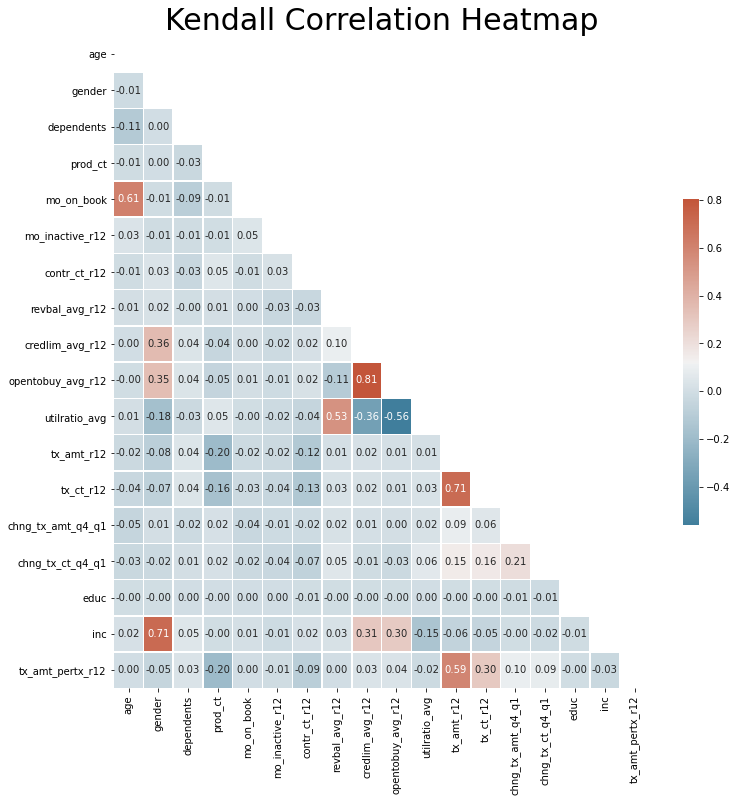

In [59]:
corr_map(d_sample, 'kendall')

In [60]:
def multicoll_ranked(d_sample, method, threshold=0.3):
    corr_abs = d_sample.rank().corr(method=method).abs()
    corr_pair = (corr_abs.where(
        np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
    corr_pair_filtered = corr_pair[(corr_pair!=1) & (corr_pair>threshold)].reset_index()
    corr_pair_filtered.columns = ['var1', 'var2', 'corr']
    print(method.title(), 'Correlation Pair')
    return(corr_pair_filtered)

In [61]:
multicoll_ranked_kendall = multicoll_ranked(d_sample, 'kendall')
multicoll_ranked_kendall

Kendall Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.81
1,gender,inc,0.71
2,tx_amt_r12,tx_ct_r12,0.71
3,age,mo_on_book,0.61
4,tx_amt_r12,tx_amt_pertx_r12,0.59
5,opentobuy_avg_r12,utilratio_avg,0.56
6,revbal_avg_r12,utilratio_avg,0.53
7,gender,credlim_avg_r12,0.36
8,credlim_avg_r12,utilratio_avg,0.36
9,gender,opentobuy_avg_r12,0.35


In [62]:
multicoll_ranked_spearman = multicoll_ranked(d_sample, 'spearman')
multicoll_ranked_spearman

Spearman Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.93
1,tx_amt_r12,tx_ct_r12,0.88
2,gender,inc,0.79
3,tx_amt_r12,tx_amt_pertx_r12,0.78
4,age,mo_on_book,0.77
5,revbal_avg_r12,utilratio_avg,0.71
6,opentobuy_avg_r12,utilratio_avg,0.69
7,tx_ct_r12,tx_amt_pertx_r12,0.45
8,gender,credlim_avg_r12,0.44
9,gender,opentobuy_avg_r12,0.43


<a id='4.2'>
    <h2 style='font-size:240%;'>
        Supervised</h2></a>

Supervised feature selection techniques consider the target variables in selecting the features that are the most important to predicting the target. These techniques can be used to remove irrelevant features.

A few ways in which we can use supervised feature selection techniques are:
1. Wrapper methods
2. Filter methods
3. Intrinsic methods

These methods are evaluated based on the resulting model's performance on a test set. 

**Wrapper feature selection methods** use different subsets of input variables to create multiple models and choose the feature combination that maximizes the model performance according to a metric. These methods are not sensitive to variable types but can be computationally expensive. RFE is one of the more common examples of a wrapper method.

**Filter feature selection methods** use statistical techniques to understand the relationship between the predictors and the target variable. Then, the resulting scores are used to filter out the input variables to be used in the model. Examples include statistical methods and feature importance methods. One must keep in mind that most of these techniques are univariate (predictors are evaluated in isolation one at a time) which may result in too many predictors and collinearity.

Finally, there are some algorithms that select features automatically as a part of learning the model. These techniques are referred to as **intrinsic feature selection methods**. These methods include penalized regression models such as Lasso and decision trees as well as ensembles of decision trees like random forest. 

We must note that some rule-based models such as the tree methods, MARS, and the lasso, are naturally resistant to non-informative predictors. 

An alternative to feature selection is a **dimensionality reduction method**. While these two are similar in that they both aim to reduce the number of features, they are different in that feature selection methods pick and choose which features to keep or remove whereas dimensionality reduction methods transform the input features entirely. 

[Source: Machine Learning Mastery - Feature Selection with Real & Categorical Data](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

For numerical predictors, we will be using the filter methods, ANOVA correlation coefficient (linear) and Kendall's rank coefficient (nonlinear). Kendall assumes categorical vaiables to be ordinal.

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Correlation Measures</h2></a>

Rank correlation can be calculated for real-valued variables. This is done by first converting the values for each variable into rank data. This is where the values are ordered and assigned an integer rank value. Rank correlation coefficients can then be calculated in order to quantify the association between the two ranked variables.

Because no distribution for the values is assumed, rank correlation methods are referred to as distribution-free correlation or nonparametric correlation. Interestingly, rank correlation measures are often used as the basis for other statistical hypothesis tests, such as determining whether two samples were likely drawn from the same (or different) population distributions.

[Source: Machine Learning Mastery - How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

1. Spearman’s Rank Correlation
2. Kendall’s Rank Correlation
3. Chi-Squared Test

In [63]:
# null: the two variables are correlated
def sig_corr(d, corr_test, sig='sig'):
    
    # create a 3 lists of variable names, coefs, and p-values for every predictor-target pair
    l_var, l_coef, l_p = [],[],[]
    for i in d.columns:
        coef, p = corr_test(d[i], d['churn'])
        l_var.append(i)
        l_coef.append(round(coef,3))
        l_p.append(round(p,3))
    
    # make 2 df's: significant and insignificant variables
    df_all = pd.DataFrame(zip(l_var, l_coef, l_p), columns=['var','coef','p'])
    df_sig = df_all.loc[df_all['p']<=.05,:].sort_values(by='coef',ascending=False)[1:].reset_index(drop=True)
    df_insig = df_all.loc[df_all['p']>.05,:].sort_values(by='coef',ascending=False).reset_index(drop=True)
    
    # return the df of significant variables by default. If sig='insig', return the df of insignificant variables
    if sig=='insig':
        print(f'The following variables are likely NOT correlated to `churn`. We fail to reject H0:\n')
        return(df_insig)
    else:
        print(f'The following variables are likely correlated to `churn`. We can safely reject H0:\n')
        return(df_sig)

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Spearman's Rank Correlation</h2></a>

This statistical method quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).

[Source: Machine Learning Mastery - How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

In [64]:
print('Spearman Correlation Pair')
multicoll_ranked_spearman

Spearman Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.93
1,tx_amt_r12,tx_ct_r12,0.88
2,gender,inc,0.79
3,tx_amt_r12,tx_amt_pertx_r12,0.78
4,age,mo_on_book,0.77
5,revbal_avg_r12,utilratio_avg,0.71
6,opentobuy_avg_r12,utilratio_avg,0.69
7,tx_ct_r12,tx_amt_pertx_r12,0.45
8,gender,credlim_avg_r12,0.44
9,gender,opentobuy_avg_r12,0.43


In [65]:
sig_spearman = sig_corr(d, spearmanr)
sig_spearman

The following variables are likely correlated to `churn`. We can safely reject H0:



,var,coef,p
0,contr_ct_r12,0.19,0.00
1,mo_inactive_r12,0.17,0.00
2,opentobuy_avg_r12,0.03,0.01
3,dependents,0.02,0.04
4,marstat_Married,-0.02,0.02
5,gender,-0.04,0.00
6,credlim_avg_r12,-0.05,0.00
7,chng_tx_amt_q4_q1,-0.10,0.00
8,prod_ct,-0.15,0.00
9,tx_amt_r12,-0.22,0.00


In [66]:
sig_spearman_abs = sig_spearman.copy()
sig_spearman_abs['coef'] = sig_spearman_abs['coef'].abs()

In [67]:
print('Absolute values of coef to examine the magnitude of impact:')
sig_spearman_abs = sig_spearman.copy()
sig_spearman_abs['coef'] = sig_spearman_abs['coef'].abs()
sig_spearman_abs = sig_spearman_abs.sort_values(by='coef', ascending=False)
sig_spearman_abs

Absolute values of coef to examine the magnitude of impact:


,var,coef,p
13,tx_ct_r12,0.38,0.00
12,chng_tx_ct_q4_q1,0.31,0.00
11,revbal_avg_r12,0.24,0.00
10,utilratio_avg,0.24,0.00
9,tx_amt_r12,0.22,0.00
0,contr_ct_r12,0.19,0.00
1,mo_inactive_r12,0.17,0.00
8,prod_ct,0.15,0.00
7,chng_tx_amt_q4_q1,0.10,0.00
6,credlim_avg_r12,0.05,0.00


In [68]:
print([*sig_spearman_abs['var']])

['tx_ct_r12', 'chng_tx_ct_q4_q1', 'revbal_avg_r12', 'utilratio_avg', 'tx_amt_r12', 'contr_ct_r12', 'mo_inactive_r12', 'prod_ct', 'chng_tx_amt_q4_q1', 'credlim_avg_r12', 'gender', 'opentobuy_avg_r12', 'marstat_Married', 'dependents']


In [69]:
var_to_keep_spearman = ['tx_ct_r12', 'chng_tx_ct_q4_q1', 'revbal_avg_r12', 'contr_ct_r12', 'mo_inactive_r12', 'prod_ct', 
               'credlim_avg_r12', 'gender', 'marstat_Married','dependents']

In [52]:
results_dic_test = results_complete(models, scaler, resampling, set_applied='test')

In [53]:
results_adasyn_test = results_summary_df(results_dic_test)
results_adasyn_test

metric accuracy      precision      recall         f1         f2     
           mean  std      mean  std   mean  std  mean  std  mean  std
mod                                                                  
LR        84.30 0.00     50.60 0.00  91.38 0.00 65.13 0.00 78.70 0.00
LDA       82.97 0.00     48.39 0.00  92.62 0.00 63.57 0.00 78.30 0.00
KNN       86.33 0.00     55.83 0.00  70.77 0.00 62.42 0.00 67.17 0.00
CART      93.14 0.00     74.22 0.00  87.69 0.00 80.39 0.00 84.62 0.00
RF        96.99 0.00     88.60 0.00  93.23 0.00 90.85 0.00 92.27 0.00
NB        79.37 0.00     42.13 0.00  76.62 0.00 54.37 0.00 65.84 0.00
GB        96.00 0.00     83.89 0.00  92.92 0.00 88.18 0.00 90.96 0.00
MLP       94.32 0.00     80.35 0.00  85.54 0.00 82.86 0.00 84.45 0.00

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Kendall's Tau</h2></a>

The intuition for the test is that it calculates a normalized score for the number of matching or concordant rankings between the two samples. As such, the test is also referred to as Kendall’s concordance test. As a statistical hypothesis test, the method assumes (H0) that there is no association between the two samples.

[Source: Machine Learning Mastery - How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

In [70]:
print('Kendall Correlation Pair')
multicoll_ranked_kendall

Kendall Correlation Pair


,var1,var2,corr
0,credlim_avg_r12,opentobuy_avg_r12,0.81
1,gender,inc,0.71
2,tx_amt_r12,tx_ct_r12,0.71
3,age,mo_on_book,0.61
4,tx_amt_r12,tx_amt_pertx_r12,0.59
5,opentobuy_avg_r12,utilratio_avg,0.56
6,revbal_avg_r12,utilratio_avg,0.53
7,gender,credlim_avg_r12,0.36
8,credlim_avg_r12,utilratio_avg,0.36
9,gender,opentobuy_avg_r12,0.35


In [71]:
sig_kendall = sig_corr(d, kendalltau)
sig_kendall

The following variables are likely correlated to `churn`. We can safely reject H0:



,var,coef,p
0,contr_ct_r12,0.17,0.00
1,mo_inactive_r12,0.16,0.00
2,opentobuy_avg_r12,0.02,0.01
3,dependents,0.02,0.04
4,marstat_Married,-0.02,0.02
5,gender,-0.04,0.00
6,credlim_avg_r12,-0.04,0.00
7,chng_tx_amt_q4_q1,-0.08,0.00
8,prod_ct,-0.13,0.00
9,tx_amt_r12,-0.18,0.00


In [72]:
insig_kendall = sig_corr(d, kendalltau, 'insig')
insig_kendall

The following variables are likely NOT correlated to `churn`. We fail to reject H0:



,var,coef,p
0,marstat_Single,0.02,0.06
1,age,0.01,0.08
2,mo_on_book,0.01,0.12
3,card_Platinum,0.01,0.28
4,marstat_Unknown,0.01,0.37
5,educ,0.01,0.40
6,card_Gold,0.01,0.55
7,card_Blue,0.00,0.75
8,marstat_Divorced,0.00,0.93
9,tx_amt_pertx_r12,-0.01,0.50


In [73]:
print('Absolute values of coef to examine the magnitude of impact:')
sig_kendall_abs = sig_kendall.copy()
sig_kendall_abs['coef'] = sig_kendall_abs['coef'].abs()
sig_kendall_abs = sig_kendall_abs.sort_values(by='coef', ascending=False)
sig_kendall_abs

Absolute values of coef to examine the magnitude of impact:


,var,coef,p
13,tx_ct_r12,0.31,0.00
12,chng_tx_ct_q4_q1,0.26,0.00
10,revbal_avg_r12,0.20,0.00
11,utilratio_avg,0.20,0.00
9,tx_amt_r12,0.18,0.00
0,contr_ct_r12,0.17,0.00
1,mo_inactive_r12,0.16,0.00
8,prod_ct,0.13,0.00
7,chng_tx_amt_q4_q1,0.08,0.00
6,credlim_avg_r12,0.04,0.00


In [74]:
print([*sig_spearman_abs['var']])

['tx_ct_r12', 'chng_tx_ct_q4_q1', 'revbal_avg_r12', 'utilratio_avg', 'tx_amt_r12', 'contr_ct_r12', 'mo_inactive_r12', 'prod_ct', 'chng_tx_amt_q4_q1', 'credlim_avg_r12', 'gender', 'opentobuy_avg_r12', 'marstat_Married', 'dependents']


In [75]:
print([*sig_kendall_abs['var']])

['tx_ct_r12', 'chng_tx_ct_q4_q1', 'revbal_avg_r12', 'utilratio_avg', 'tx_amt_r12', 'contr_ct_r12', 'mo_inactive_r12', 'prod_ct', 'chng_tx_amt_q4_q1', 'credlim_avg_r12', 'gender', 'marstat_Married', 'opentobuy_avg_r12', 'dependents']


In [76]:
var_to_keep = ['churn', 'tx_ct_r12', 'chng_tx_ct_q4_q1', 'revbal_avg_r12', 'contr_ct_r12', 'mo_inactive_r12', 'prod_ct', 
               'credlim_avg_r12', 'gender', 'marstat_Married','dependents']

In [77]:
sig_kendall_filtered = sig_corr(d[var_to_keep], kendalltau)
sig_kendall_filtered

The following variables are likely correlated to `churn`. We can safely reject H0:



,var,coef,p
0,contr_ct_r12,0.17,0.00
1,mo_inactive_r12,0.16,0.00
2,dependents,0.02,0.04
3,marstat_Married,-0.02,0.02
4,gender,-0.04,0.00
5,credlim_avg_r12,-0.04,0.00
6,prod_ct,-0.13,0.00
7,revbal_avg_r12,-0.20,0.00
8,chng_tx_ct_q4_q1,-0.26,0.00
9,tx_ct_r12,-0.31,0.00


In [85]:
d_values = d[var_to_keep].values
x, y = d_values[:,1:], d_values[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

In [86]:
results_dic_test = results_complete(models, scaler, resampling, set_applied='test')

In [87]:
results_adasyn_test2 = results_summary_df(results_dic_test)
results_adasyn_test2

metric accuracy      precision      recall         f1         f2     
           mean  std      mean  std   mean  std  mean  std  mean  std
mod                                                                  
LR        77.64 0.00     40.83 0.00  87.69 0.00 55.72 0.00 71.32 0.00
LDA       76.16 0.00     39.27 0.00  88.92 0.00 54.48 0.00 70.97 0.00
KNN       85.44 0.00     53.68 0.00  67.38 0.00 59.75 0.00 64.11 0.00
CART      88.20 0.00     60.97 0.00  73.54 0.00 66.67 0.00 70.63 0.00
RF        92.79 0.00     75.79 0.00  80.92 0.00 78.27 0.00 79.84 0.00
NB        76.31 0.00     39.37 0.00  88.31 0.00 54.46 0.00 70.72 0.00
GB        92.05 0.00     71.47 0.00  84.00 0.00 77.23 0.00 81.15 0.00
MLP       88.10 0.00     58.50 0.00  88.92 0.00 70.57 0.00 80.55 0.00

In [85]:
d_values = d.values
x, y = d_values[:,1:], d_values[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

# ANOVA F-Classifier

In [78]:
# d[var_to_keep]

In [79]:
ref = {}
for i in np.arange(x_train.shape[1]):
    ref[i]=d.iloc[:,1:].columns[i]

In [80]:
# Compute the ANOVA F-value for the provided sample.
from sklearn.feature_selection import f_classif
f, p = f_classif(x_train, y_train)

In [81]:
pval_ftest = pd.DataFrame(p, columns=['p-val'])
pval_ftest.index = d.iloc[:,1:].columns

In [82]:
# pval_ftest.style.set_table_attributes('style="font-size: 15px"')

In [83]:
pval_ftest[pval_ftest['p-val']<.16]

,p-val
age,0.11
gender,0.00
dependents,0.11
prod_ct,0.00
mo_on_book,0.08
mo_inactive_r12,0.00
contr_ct_r12,0.00
revbal_avg_r12,0.00
credlim_avg_r12,0.04
utilratio_avg,0.00


In [ ]:
X_indices = np.arange(x_train.shape[-1])

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features

selector = SelectKBest(f_classif, k=7)
selector.fit(x_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(X_indices - .45, scores, width=.8,
        label=r'Univariate score ($-Log(p_{value})$)')
plt.xlabel('Features')
plt.xticks(X_indices, d.iloc[:,1:].columns, rotation=30)
plt.show()

In [ ]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=8)
# apply feature selection
x_selected = fs.fit_transform(x_train, y_train)
print(x_selected.shape)

For categorical predictors, we will use the chi-squared test and mutual information (information gain) from the field of information theory. Mutual information is agnostic to the data types.

# Filtered Data Anova

In [ ]:
d_values = d[var_to_keep].values
x, y = d_values[:,1:], d_values[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

In [ ]:
ref = {}
for i in np.arange(x_train.shape[1]):
    ref[i]=d.iloc[:,1:].columns[i]

In [ ]:
# Compute the ANOVA F-value for the provided sample.
from sklearn.feature_selection import f_classif
f, p = f_classif(x_train, y_train)

In [ ]:
pval_ftest = pd.DataFrame(p, columns=['p-val'])
pval_ftest.index = d[var_to_keep].iloc[:,1:].columns

In [ ]:
# pval_ftest.style.set_table_attributes('style="font-size: 15px"')

In [ ]:
pval_ftest[pval_ftest['p-val']<.16]

In [ ]:
X_indices = np.arange(x_train.shape[-1])

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features

selector = SelectKBest(f_classif, k=7)
selector.fit(x_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(X_indices - .45, scores, width=.8,
        label=r'Univariate score ($-Log(p_{value})$)')
plt.xlabel('Features')
plt.xticks(X_indices, d[var_to_keep].iloc[:,1:].columns, rotation=30)
plt.show()

In [ ]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=8)
# apply feature selection
x_selected = fs.fit_transform(x_train, y_train)
print(x_selected.shape)

# RFE

In [ ]:
# report which features were selected by RFE
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# load data
d = pd.read_csv('source/d_num.csv')
d = d.values
x = d[:,1:]
y = d[:,:1].ravel()

# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8)

# fit RFE
rfe.fit(x_train, y_train)

In [ ]:
d = pd.read_csv('source/d_num.csv')

In [ ]:
d_RFE = pd.DataFrame(zip(d.columns[1:], rfe.ranking_), columns=['Variable', 'Ranking']).sort_values(by='Ranking').reset_index(drop=True)

In [ ]:
d_RFE